In [1]:
!pip install -q efficientnet
import pandas as pd
import numpy as np
from scipy import stats
import random
import os
import tensorflow as tf
import math
import cv2
from sklearn.model_selection import train_test_split
from tensorflow import keras
from tensorflow.keras import layers
import re
import tensorflow.keras.applications.efficientnet as eff
import tensorflow.keras.applications as tfka
import efficientnet.tfkeras as efn
from sklearn import metrics
import gc
from tensorflow.keras import backend as K
import tensorflow_addons as tfa
from tqdm.notebook import tqdm
from kaggle_datasets import KaggleDatasets
import tensorflow_addons as tfa
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
user_credential = user_secrets.get_gcloud_credential()
user_secrets.set_tensorflow_credential(user_credential)
from matplotlib import pyplot as plt
%matplotlib inline

2021-11-29 07:18:44.641107: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-29 07:18:44.641230: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2021-11-29 07:18:49.916585: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2021-11-29 07:18:49.919502: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /opt/conda/lib
2021-11-29 07:18:49.919543: W tensorflow/stream_executor/cuda/cuda_driver.cc:326] failed call to cuInit: UNKNOWN ERROR (303)
2021-11-29 07:18:49.919580: I tensorflow/stream_executor/cuda/cud

In [2]:
try:
    # TPU detection. No parameters necessary if TPU_NAME environment variable is
    # set: this is always the case on Kaggle.
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.TPUStrategy(tpu)
else:
    # Default distribution strategy in Tensorflow. Works on CPU and single GPU.
    strategy = tf.distribute.get_strategy()

print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.0.0.2:8470


2021-11-29 07:18:51.108761: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-29 07:18:51.108855: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2021-11-29 07:18:51.133985: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job worker -> {0 -> 10.0.0.2:8470}
2021-11-29 07:18:51.134055: I tensorflow/core/distributed_runtime/rpc/grpc_channel.cc:301] Initialize GrpcChannelCache for job localhost -> {0 -> localhost:30020}
2021-11-29 07:18:51.134874: I tensorflow/core/distributed_runtime/rpc/grpc_server_lib.cc:411] Started server with target: grpc://localhost:30020


REPLICAS:  8


In [3]:
# Configuration
# For tf.dataset
AUTO = tf.data.experimental.AUTOTUNE

EPOCHS = 15
BATCH_SIZE = 32
IMAGE_SIZE = [256, 256]
# Seed
SEED = 9527
seed = 9527
# Learning rate
LR = 0.0005
# Verbosity
VERBOSE = 2
# Label_dim
label_dim = 35

# dataset path

img_path = '../input/deepfoodie/dataset_1_images/dataset_1_images/Food Images/'
GCS_PATH = KaggleDatasets().get_gcs_path('deepfoodiedataloaders')

train_set = tf.io.gfile.glob(GCS_PATH + '/train' + '*.tfrec')
val_set = tf.io.gfile.glob(GCS_PATH + '/val' + '*.tfrec')

TARGET = "cleaned_ingredients"
VOCAB_SIZE = 13528
TITLE_EMBEDDING_SIZE = 50

In [4]:
def seed_everything(seed):
    random.seed(seed)
    np.random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    tf.random.set_seed(seed)
    
# Data augmentation function
def data_augment(input1, label):
#     print(len(image), image)
    image = input1["inp1"]
    image = tf.image.random_flip_left_right(image)
    image = tf.image.random_flip_up_down(image)
    image = tf.image.random_hue(image, 0.01)
    image = tf.image.random_saturation(image, 0.70, 1.30)
    image = tf.image.random_contrast(image, 0.80, 1.20)
    image = tf.image.random_brightness(image, 0.10)
    return {"inp1": image, "inp2": tf.expand_dims(input1["inp2"], -1)}, label

# Function to decode our images
def decode_image(image_data):
    image = tf.image.decode_jpeg(image_data, channels = 3)
    image = tf.image.resize(image, IMAGE_SIZE)
    image = tf.cast(image, tf.float32) / 255.0
    return image


# This function parse our images and also get the target variable
def read_labeled_tfrecord(example):
    LABELED_TFREC_FORMAT = {
        "image_name": tf.io.FixedLenFeature([], tf.string),
        "image": tf.io.FixedLenFeature([], tf.string),
        "cleaned_ingredients": tf.io.FixedLenSequenceFeature([], dtype=tf.int64, allow_missing=True),
        "orig_ingredients": tf.io.FixedLenFeature([], tf.string),
        "title": tf.io.FixedLenSequenceFeature([], dtype=tf.float32, allow_missing=True),
        "instructions": tf.io.FixedLenFeature([], tf.string),
    }

    example = tf.io.parse_single_example(example, LABELED_TFREC_FORMAT)
    
    image = decode_image(example['image'])
    title = example['title']
    label = example['cleaned_ingredients']

    
    return  {"inp1": image, "inp2": title}, label

def load_dataset(filenames, target, ordered = False):
    
    ignore_order = tf.data.Options()
    if not ordered:
        ignore_order.experimental_deterministic = False 
        
    dataset = tf.data.TFRecordDataset(filenames, num_parallel_reads = AUTO)
    dataset = dataset.with_options(ignore_order)
    dataset = dataset.map(read_labeled_tfrecord, num_parallel_calls = AUTO) 
    return dataset

# This function is to get our training tensors
def get_training_dataset(filenames, target, ordered = False):
    dataset = load_dataset(filenames, target, ordered = ordered)
    
    dataset = dataset.map(data_augment, num_parallel_calls = AUTO)
    dataset = dataset.repeat()
    dataset = dataset.shuffle(2048)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO)
    return dataset

# This function is to get our validation tensors
def get_validation_dataset(filenames, target, ordered = True):
    dataset = load_dataset(filenames, target, ordered = ordered)
    dataset = dataset.batch(BATCH_SIZE)
    dataset = dataset.prefetch(AUTO) 
    return dataset

# Function to count how many photos we have in
def count_data_items(filenames):
    # The number of data items is written in the name of the .tfrec files, i.e. flowers00-230.tfrec = 230 data items
    n = [int(re.compile(r"-([0-9]*)\.").search(filename).group(1)) for filename in filenames]
    return np.sum(n)

NUM_TRAINING_IMAGES = count_data_items(train_set)
print(f'Dataset: {NUM_TRAINING_IMAGES} training images')

Dataset: 10092 training images


In [5]:
train_dataset = get_training_dataset(train_set, TARGET, ordered = False)

In [6]:
for fo in train_dataset.take(1):
    print(fo)

({'inp1': <tf.Tensor: shape=(32, 256, 256, 3), dtype=float32, numpy=
array([[[[ 0.183976  ,  0.22095615,  0.31457052],
         [ 0.3028783 ,  0.35155144,  0.44112036],
         [ 0.24610537,  0.31478402,  0.41493765],
         ...,
         [ 0.8234236 ,  0.8560812 ,  0.82279074],
         [ 0.83543503,  0.86044496,  0.8388475 ],
         [ 0.83543503,  0.86044496,  0.8388475 ]],

        [[ 0.19270357,  0.22968376,  0.32329813],
         [ 0.27287182,  0.32930326,  0.41493765],
         [ 0.2373778 ,  0.30605647,  0.40621004],
         ...,
         [ 0.83215123,  0.8648088 ,  0.8315183 ],
         [ 0.83979875,  0.8648087 ,  0.8432113 ],
         [ 0.83107114,  0.8560812 ,  0.8344837 ]],

        [[ 0.21996632,  0.26863948,  0.3582084 ],
         [ 0.22050634,  0.2769378 ,  0.36257216],
         [ 0.2024675 ,  0.27114615,  0.37129977],
         ...,
         [ 0.8408788 ,  0.87353635,  0.84024584],
         [ 0.8441626 ,  0.8691726 ,  0.84757507],
         [ 0.83543503,  0.86044496,

2021-11-29 07:19:00.013550: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 34, Output num: 1
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638170340.010148076","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 34, Output num: 1","grpc_status":3}


In [7]:
val_dataset = get_validation_dataset(val_set, TARGET, ordered = True)

In [8]:
STEPS_PER_EPOCH = count_data_items(train_set) // BATCH_SIZE
K.clear_session()


In [9]:
def get_lr_callback():
    # lr_start   = 0.0000001
    # lr_max     = 0.000005 * BATCH_SIZE
    lr_min     = 0.0000001
    lr_ramp_ep = 5
    lr_sus_ep  = 0
    lr_decay   = 0.8
   
    def lrfn(epoch):
        if epoch < EPOCHS/2:
            lr = 0.000001 * (BATCH_SIZE - epoch)
        else:
            lr = lr_min
        return lr

    lr_callback = tf.keras.callbacks.LearningRateScheduler(lrfn, verbose = True)
    return lr_callback

In [10]:
def get_model(mode):

    with strategy.scope():

        inp = tf.keras.layers.Input(shape = (*IMAGE_SIZE, 3), name = 'inp1')
        inp2 = tf.keras.layers.Input(shape = (TITLE_EMBEDDING_SIZE, 1, ), name='inp2')
        print(f'load Model_{mode}')
        y = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(128))(inp2)
#         y = tf.keras.layers.Reshape((50, 1))(inp2)
        y = tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(128, return_sequences=True))(y)
        
#         y = tf.keras.layers.Dropout(.3)(y)
        if mode == 'eff0':
            x = efn.EfficientNetB0(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff1':
            x = efn.EfficientNetB1(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff2':
            x = efn.EfficientNetB2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff3':
            x = efn.EfficientNetB3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff4':
            x = efn.EfficientNetB4(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff5':
            x = efn.EfficientNetB5(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff6':
            x = efn.EfficientNetB6(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'eff7':
            x = efn.EfficientNetB7(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV2':
            x = tfka.InceptionResNetV2(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'ICPV3':
            x = tfka.InceptionV3(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'XCP':
            x = tfka.Xception(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG16':
            x = tfka.VGG16(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'VGG19':
            x = tfka.VGG19(weights = 'imagenet', include_top = False)(inp)
        elif mode == 'RN50':
            x = tfka.ResNet50(weights = 'imagenet', include_top = False)(inp)
        else:
            # 'RN101'
            x = tfka.ResNet101(weights = 'imagenet', include_top = False)(inp)
        x = tf.keras.layers.GlobalAveragePooling2D()(x)
        
        x = tf.keras.layers.Dense(256)(x)
        x = tf.keras.layers.add([x, y])
        x = tf.keras.layers.Flatten()(x)
        output = tf.keras.layers.Dense(VOCAB_SIZE, activation='sigmoid')(x)

        model = tf.keras.models.Model(inputs = [inp, inp2], outputs = [output])
        opt = tf.keras.optimizers.Adam(learning_rate = LR)

        model.compile(
            optimizer = opt,
            loss="binary_crossentropy"

            ) 
        print(model.summary())
        return model

In [11]:
def plot_model(mode):
    model = get_model(mode=mode)
    checkpoint = tf.keras.callbacks.ModelCheckpoint(f'Model_{mode}_{505}.h5', 
                                                        monitor = 'val_loss', 
                                                        verbose = 2, 
                                                        save_best_only = True,
                                                        save_weights_only = True, 
                                                        mode = 'min')
    history = model.fit(train_dataset,
                            steps_per_epoch = STEPS_PER_EPOCH,
                            epochs = EPOCHS,
                            callbacks = [checkpoint, get_lr_callback()], 
                            validation_data = val_dataset,
                            verbose = VERBOSE)
    
    gc.collect()
    plt.figure(figsize=(20,10))
    plt.plot(history.history['loss'], label='train_loss')
    plt.plot(history.history['val_loss'], label='val_loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

load Model_eff1
27164672/27164032 [==============================] - 0s 0us/step
Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b1 (Functional)    (None, None, None, 1 6575232     inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d (Globa (None, 1280)         0           efficientnet-b1[0][0]            
_____________

2021-11-29 07:21:12.446946: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 39269, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638170472.445949955","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 39269, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.03914, saving model to Model_eff1_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 29s - loss: 0.0041 - val_loss: 0.0278

Epoch 00002: val_loss improved from 0.03914 to 0.02781, saving model to Model_eff1_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 29s - loss: 0.0040 - val_loss: 0.0228

Epoch 00003: val_loss improved from 0.02781 to 0.02280, saving model to Model_eff1_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 29s - loss: 0.0040 - val_loss: 0.0181

Epoch 00004: val_loss improved from 0.02280 to 0.01812, saving model to Model_eff1_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 29s - loss: 0.0039 - val_loss: 0.0166

Epoch 00005: val_loss improved from 0.01812 to 0.01663, saving model to Model_eff1_505.h5
Epoch 6/15

Ep

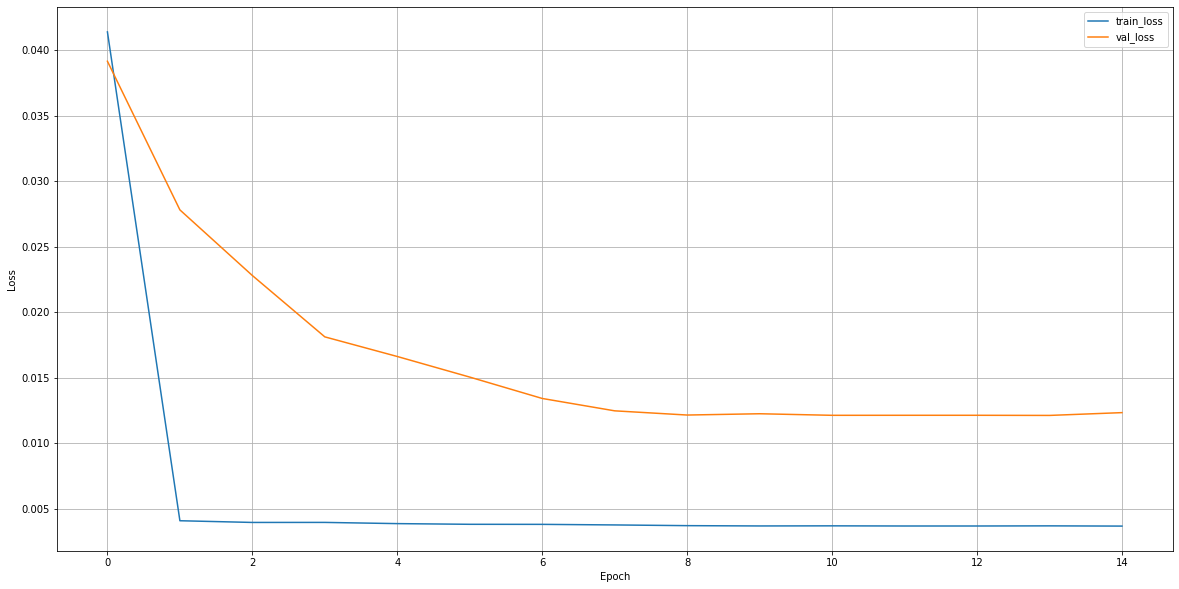

In [12]:
models = ['eff1','eff2','eff3','eff4','eff5','eff6','eff7','XCP', 'RN50']
plot_model(models[0])

load Model_eff2
31940608/31936256 [==============================] - 1s 0us/step
Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b2 (Functional)    (None, None, None, 1 7768562     inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d_1 (Glo (None, 1408)         0           efficientnet-b2[0][0]            
___________

2021-11-29 07:31:30.997523: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 131081, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638171090.997096868","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 131081, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.03037, saving model to Model_eff2_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 30s - loss: 0.0041 - val_loss: 0.0189

Epoch 00002: val_loss improved from 0.03037 to 0.01891, saving model to Model_eff2_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 30s - loss: 0.0040 - val_loss: 0.0158

Epoch 00003: val_loss improved from 0.01891 to 0.01579, saving model to Model_eff2_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 39s - loss: 0.0039 - val_loss: 0.0133

Epoch 00004: val_loss improved from 0.01579 to 0.01335, saving model to Model_eff2_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 30s - loss: 0.0039 - val_loss: 0.0122

Epoch 00005: val_loss improved from 0.01335 to 0.01217, saving model to Model_eff2_505.h5
Epoch 6/15

Ep

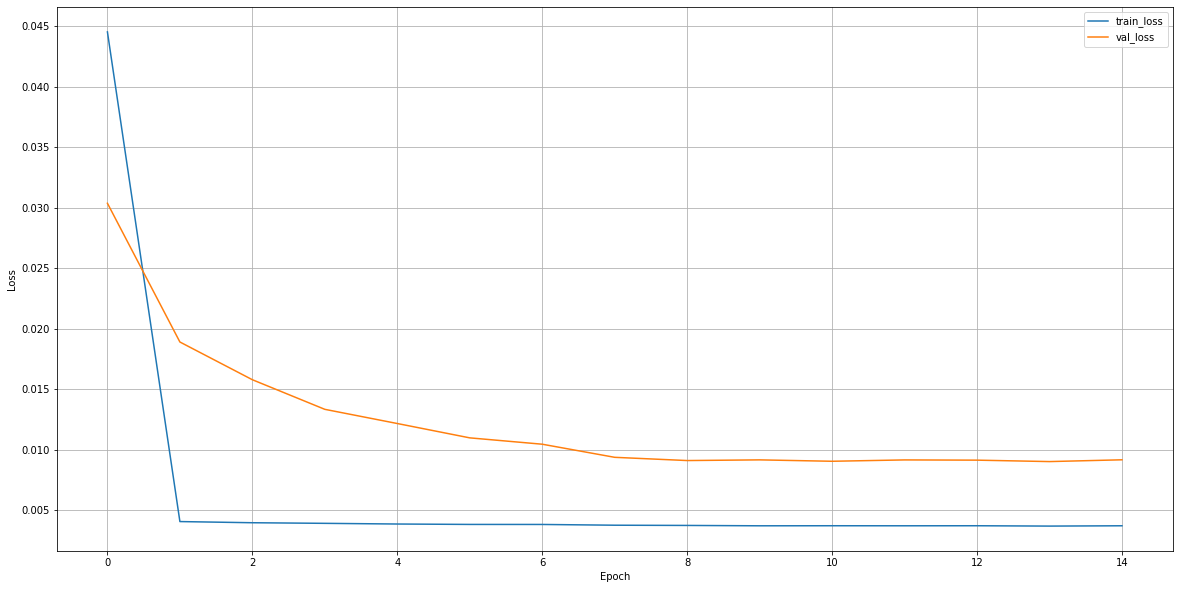

In [13]:
plot_model(models[1])

load Model_eff3
44113920/44107200 [==============================] - 1s 0us/step
Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b3 (Functional)    (None, None, None, 1 10783528    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d_2 (Glo (None, 1536)         0           efficientnet-b3[0][0]            
___________

2021-11-29 07:42:20.224787: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 227736, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638171740.224622629","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 227736, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.05158, saving model to Model_eff3_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 32s - loss: 0.0041 - val_loss: 0.0338

Epoch 00002: val_loss improved from 0.05158 to 0.03384, saving model to Model_eff3_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 32s - loss: 0.0040 - val_loss: 0.0277

Epoch 00003: val_loss improved from 0.03384 to 0.02766, saving model to Model_eff3_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 32s - loss: 0.0039 - val_loss: 0.0230

Epoch 00004: val_loss improved from 0.02766 to 0.02303, saving model to Model_eff3_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 32s - loss: 0.0039 - val_loss: 0.0212

Epoch 00005: val_loss improved from 0.02303 to 0.02120, saving model to Model_eff3_505.h5
Epoch 6/15

Ep

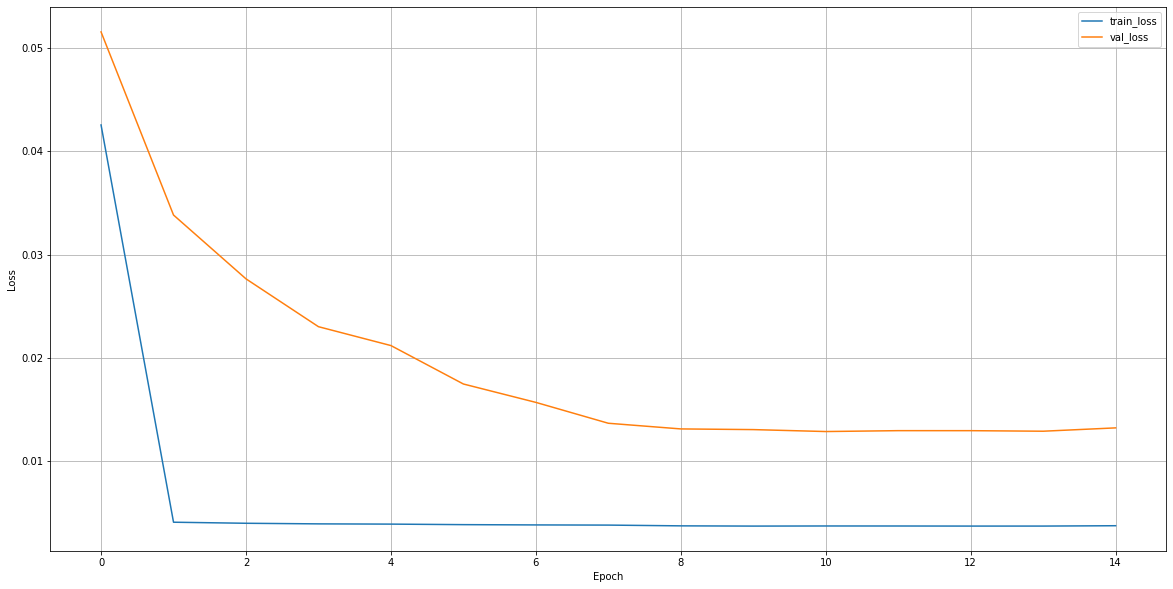

In [14]:
plot_model(models[2])

load Model_eff4
71892992/71892840 [==============================] - 1s 0us/step
Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b4 (Functional)    (None, None, None, 1 17673816    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d_3 (Glo (None, 1792)         0           efficientnet-b4[0][0]            
___________

2021-11-29 07:54:03.069841: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 339254, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638172443.069771670","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 339254, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.29720, saving model to Model_eff4_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 36s - loss: 0.0046 - val_loss: 0.1572

Epoch 00002: val_loss improved from 0.29720 to 0.15717, saving model to Model_eff4_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 36s - loss: 0.0042 - val_loss: 0.1066

Epoch 00003: val_loss improved from 0.15717 to 0.10656, saving model to Model_eff4_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 36s - loss: 0.0041 - val_loss: 0.0813

Epoch 00004: val_loss improved from 0.10656 to 0.08132, saving model to Model_eff4_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 36s - loss: 0.0040 - val_loss: 0.0698

Epoch 00005: val_loss improved from 0.08132 to 0.06980, saving model to Model_eff4_505.h5
Epoch 6/15

Ep

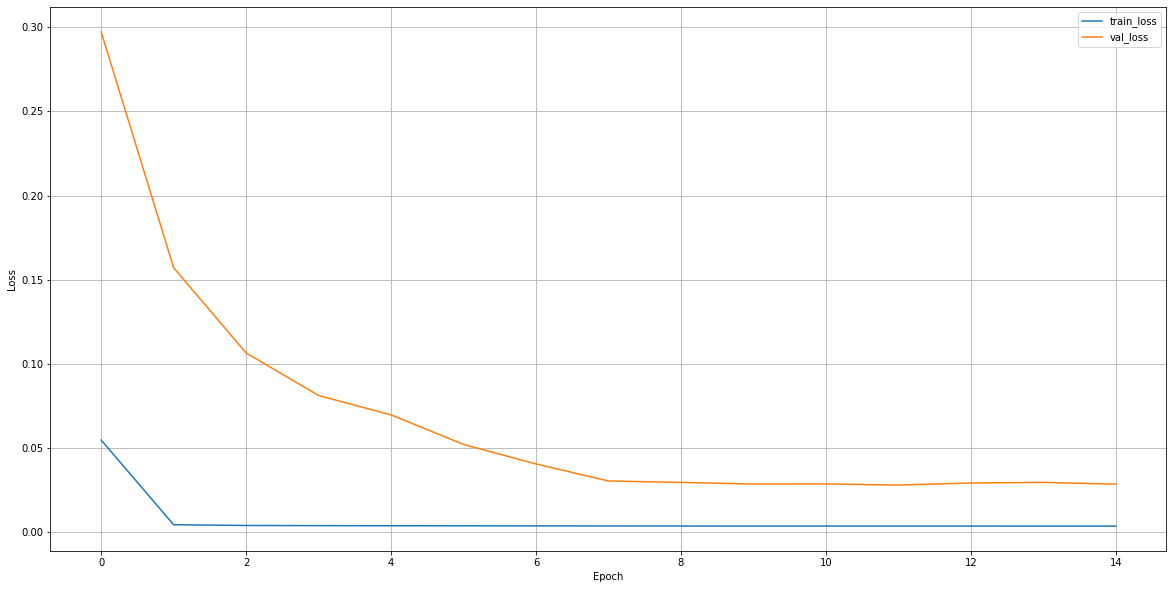

In [15]:
plot_model(models[3])

load Model_eff5
115515392/115515256 [==============================] - 5s 0us/step
Model: "model_4"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b5 (Functional)    (None, None, None, 2 28513520    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d_4 (Glo (None, 2048)         0           efficientnet-b5[0][0]            
_________

2021-11-29 08:07:32.837250: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 472008, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638173252.836769474","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 472008, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.21324, saving model to Model_eff5_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 42s - loss: 0.0046 - val_loss: 0.0428

Epoch 00002: val_loss improved from 0.21324 to 0.04276, saving model to Model_eff5_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 42s - loss: 0.0043 - val_loss: 0.0252

Epoch 00003: val_loss improved from 0.04276 to 0.02518, saving model to Model_eff5_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 42s - loss: 0.0041 - val_loss: 0.0208

Epoch 00004: val_loss improved from 0.02518 to 0.02084, saving model to Model_eff5_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 42s - loss: 0.0040 - val_loss: 0.0155

Epoch 00005: val_loss improved from 0.02084 to 0.01546, saving model to Model_eff5_505.h5
Epoch 6/15

Ep

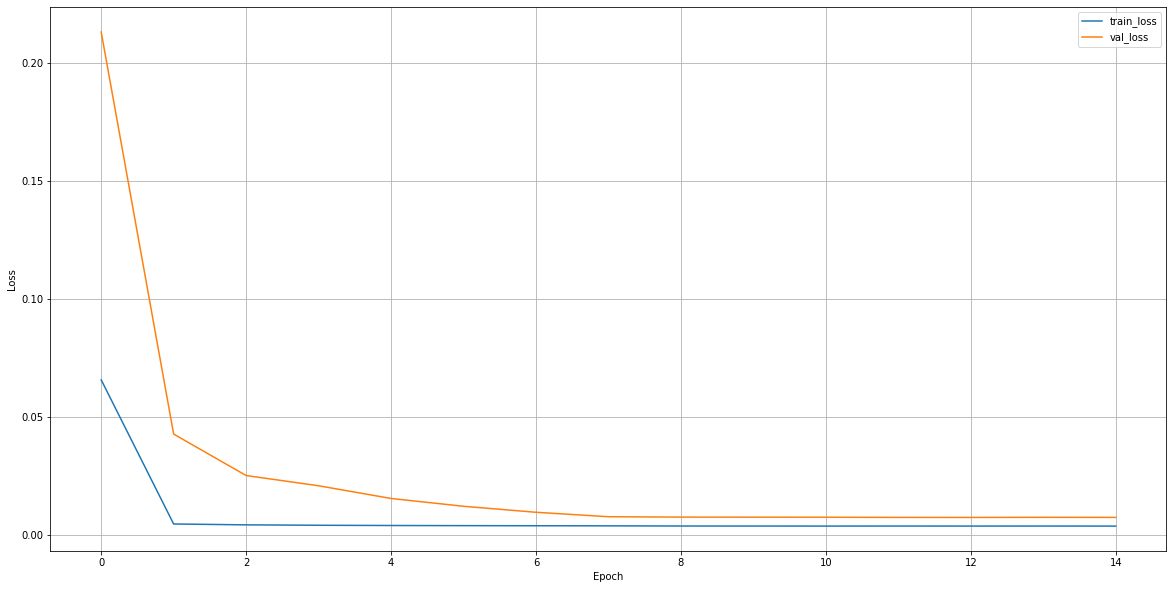

In [16]:
plot_model(models[4])

load Model_eff6
165527552/165527152 [==============================] - 12s 0us/step
Model: "model_5"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b6 (Functional)    (None, None, None, 2 40960136    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d_5 (Glo (None, 2304)         0           efficientnet-b6[0][0]            
________

2021-11-29 08:23:25.124281: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 635732, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638174205.123698054","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 635732, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.06474, saving model to Model_eff6_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 47s - loss: 0.0047 - val_loss: 0.0190

Epoch 00002: val_loss improved from 0.06474 to 0.01898, saving model to Model_eff6_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 47s - loss: 0.0043 - val_loss: 0.0112

Epoch 00003: val_loss improved from 0.01898 to 0.01121, saving model to Model_eff6_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 47s - loss: 0.0041 - val_loss: 0.0084

Epoch 00004: val_loss improved from 0.01121 to 0.00841, saving model to Model_eff6_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 47s - loss: 0.0040 - val_loss: 0.0064

Epoch 00005: val_loss improved from 0.00841 to 0.00638, saving model to Model_eff6_505.h5
Epoch 6/15

Ep

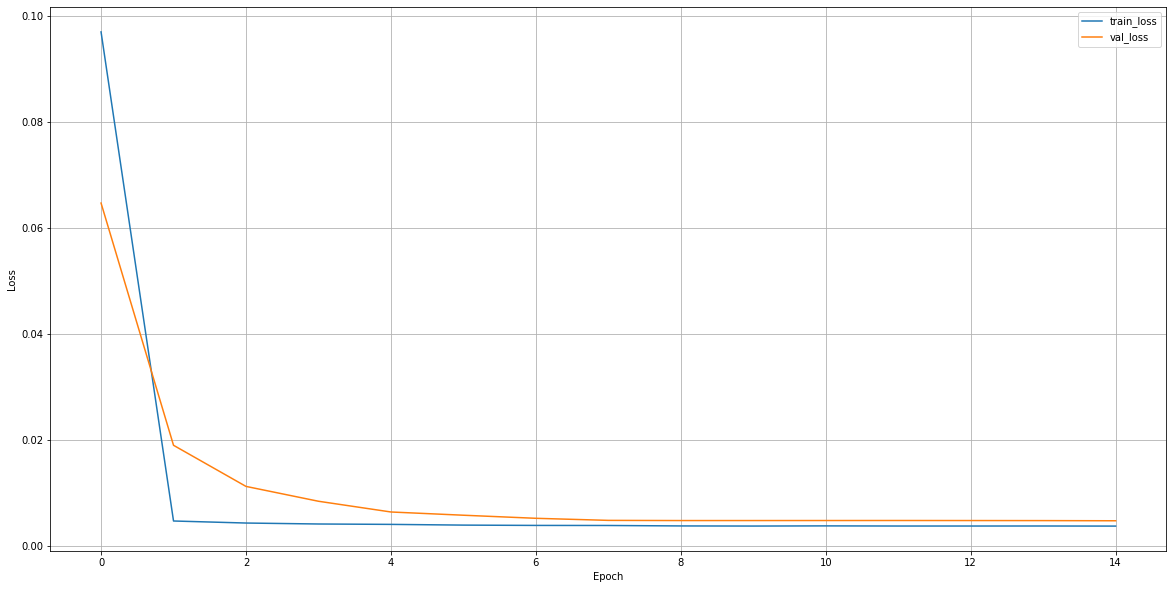

In [17]:
plot_model(models[5])

load Model_eff7
258441216/258434480 [==============================] - 3s 0us/step
Model: "model_6"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b7 (Functional)    (None, None, None, 2 64097680    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d_6 (Glo (None, 2560)         0           efficientnet-b7[0][0]            
_________

2021-11-29 08:41:10.584139: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 815834, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638175270.583600954","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 815834, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.00647, saving model to Model_eff7_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 57s - loss: 0.0045 - val_loss: 0.0047

Epoch 00002: val_loss improved from 0.00647 to 0.00471, saving model to Model_eff7_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 57s - loss: 0.0043 - val_loss: 0.0042

Epoch 00003: val_loss improved from 0.00471 to 0.00422, saving model to Model_eff7_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 58s - loss: 0.0041 - val_loss: 0.0041

Epoch 00004: val_loss improved from 0.00422 to 0.00410, saving model to Model_eff7_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 57s - loss: 0.0040 - val_loss: 0.0041

Epoch 00005: val_loss improved from 0.00410 to 0.00406, saving model to Model_eff7_505.h5
Epoch 6/15

Ep

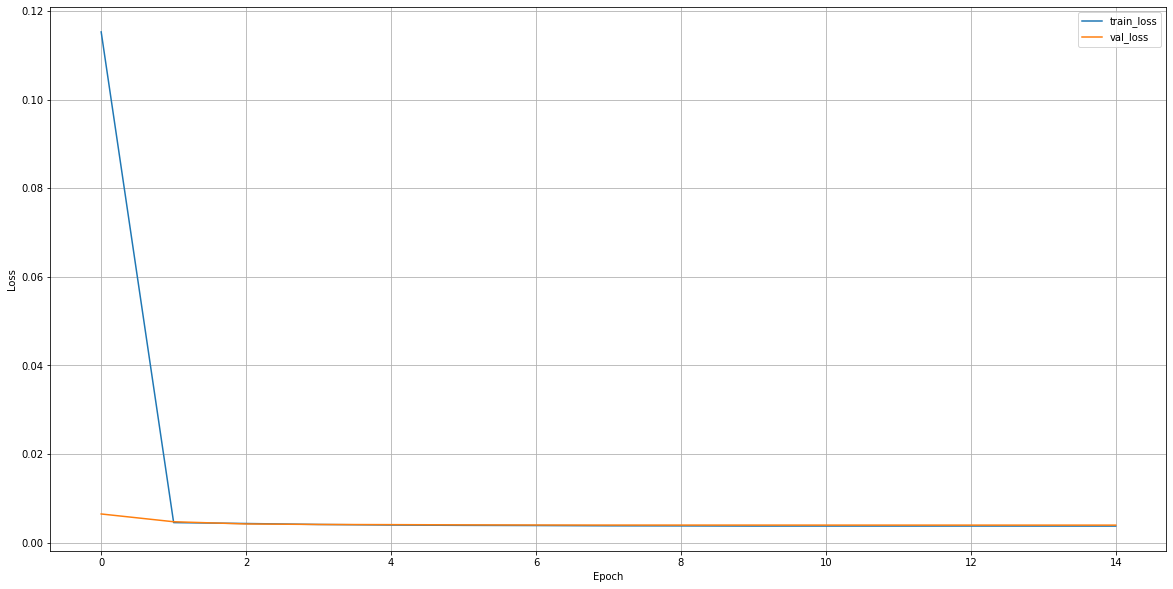

In [18]:
plot_model(models[6])

load Model_XCP
83689472/83683744 [==============================] - 0s 0us/step
Model: "model_7"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
xception (Functional)           (None, None, None, 2 20861480    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d_7 (Glo (None, 2048)         0           xception[0][0]                   
____________

2021-11-29 08:58:22.520036: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 951702, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638176302.519406163","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 951702, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.00458, saving model to Model_XCP_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 26s - loss: 0.0040 - val_loss: 0.0044

Epoch 00002: val_loss improved from 0.00458 to 0.00438, saving model to Model_XCP_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 26s - loss: 0.0039 - val_loss: 0.0042

Epoch 00003: val_loss improved from 0.00438 to 0.00421, saving model to Model_XCP_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 26s - loss: 0.0039 - val_loss: 0.0041

Epoch 00004: val_loss improved from 0.00421 to 0.00413, saving model to Model_XCP_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 33s - loss: 0.0038 - val_loss: 0.0041

Epoch 00005: val_loss improved from 0.00413 to 0.00405, saving model to Model_XCP_505.h5
Epoch 6/15

Epoch 0

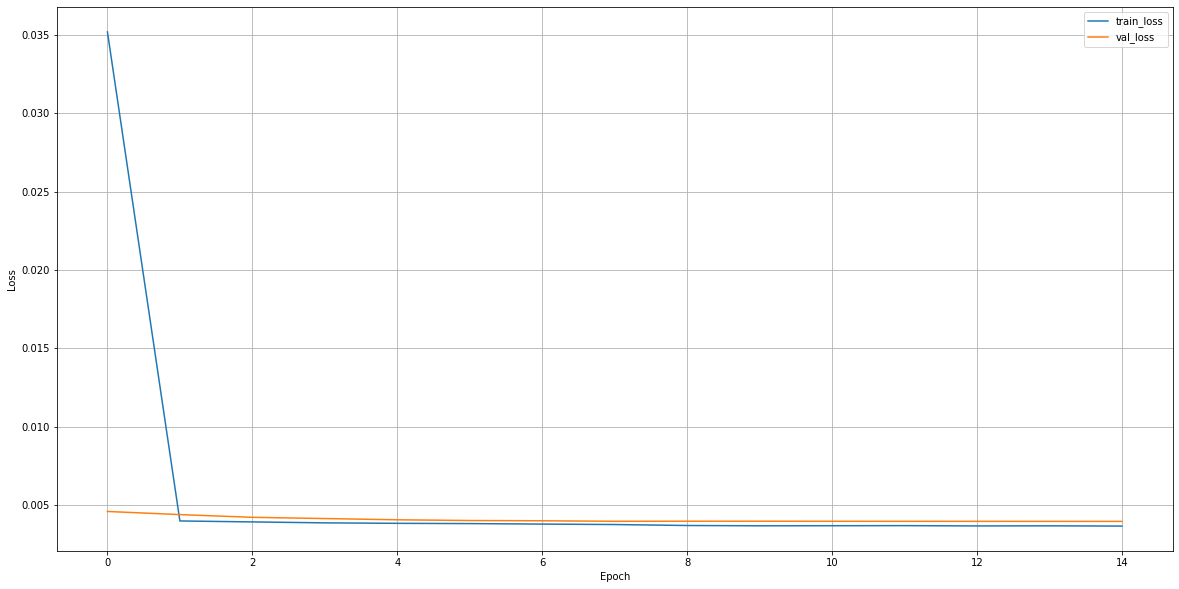

In [19]:
plot_model(models[7])

load Model_eff7
Model: "model_8"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
inp1 (InputLayer)               [(None, 256, 256, 3) 0                                            
__________________________________________________________________________________________________
efficientnet-b7 (Functional)    (None, None, None, 2 64097680    inp1[0][0]                       
__________________________________________________________________________________________________
inp2 (InputLayer)               [(None, 50, 1)]      0                                            
__________________________________________________________________________________________________
global_average_pooling2d_8 (Glo (None, 2560)         0           efficientnet-b7[0][0]            
____________________________________________________________________________

2021-11-29 09:11:00.152281: W ./tensorflow/core/distributed_runtime/eager/destroy_tensor_handle_node.h:57] Ignoring an error encountered when deleting remote tensors handles: Invalid argument: Unable to find the relevant tensor remote_handle: Op ID: 1098021, Output num: 0
Additional GRPC error information from remote target /job:worker/replica:0/task:0:
:{"created":"@1638177060.152104297","description":"Error received from peer ipv4:10.0.0.2:8470","file":"external/com_github_grpc_grpc/src/core/lib/surface/call.cc","file_line":1056,"grpc_message":"Unable to find the relevant tensor remote_handle: Op ID: 1098021, Output num: 0","grpc_status":3}



Epoch 00001: val_loss improved from inf to 0.00666, saving model to Model_eff7_505.h5
Epoch 2/15

Epoch 00002: LearningRateScheduler reducing learning rate to 3.1e-05.
315/315 - 58s - loss: 0.0046 - val_loss: 0.0047

Epoch 00002: val_loss improved from 0.00666 to 0.00471, saving model to Model_eff7_505.h5
Epoch 3/15

Epoch 00003: LearningRateScheduler reducing learning rate to 2.9999999999999997e-05.
315/315 - 57s - loss: 0.0042 - val_loss: 0.0042

Epoch 00003: val_loss improved from 0.00471 to 0.00424, saving model to Model_eff7_505.h5
Epoch 4/15

Epoch 00004: LearningRateScheduler reducing learning rate to 2.9e-05.
315/315 - 57s - loss: 0.0040 - val_loss: 0.0041

Epoch 00004: val_loss improved from 0.00424 to 0.00410, saving model to Model_eff7_505.h5
Epoch 5/15

Epoch 00005: LearningRateScheduler reducing learning rate to 2.8e-05.
315/315 - 57s - loss: 0.0039 - val_loss: 0.0040

Epoch 00005: val_loss improved from 0.00410 to 0.00403, saving model to Model_eff7_505.h5
Epoch 6/15

Ep

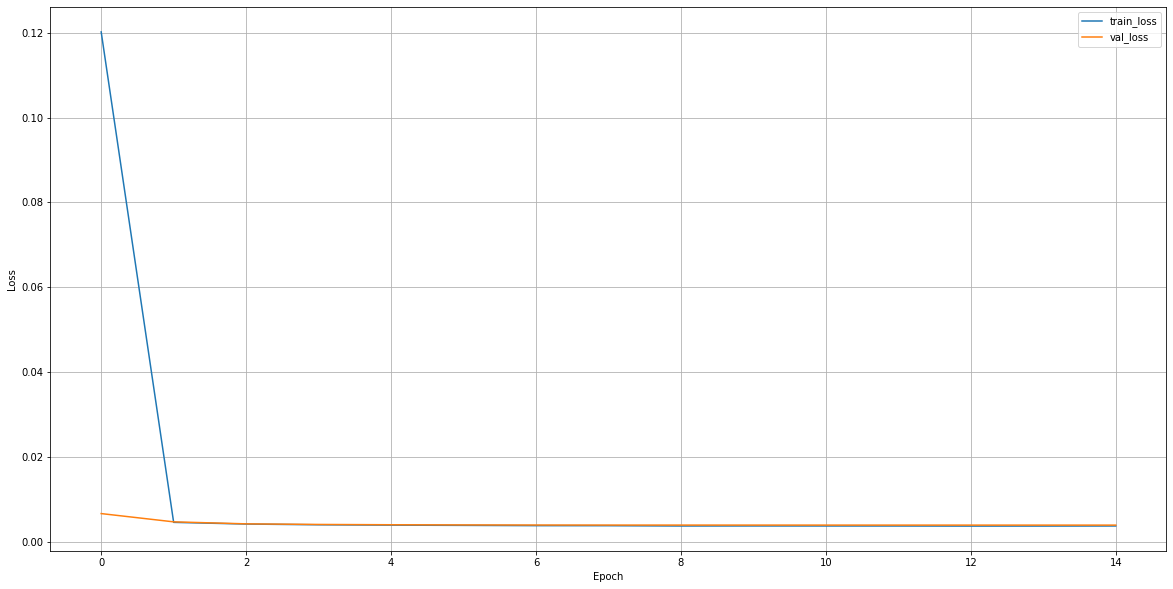

In [20]:
plot_model(models[6])